# NBA Games Analysis
The goal of this project is to build a handful of different models to make a predictive model for NBA games. The dataset used has four seasons of data from 2014-2018, not including playoff or preseason games. This data is available publicly via Kaggle. 

### Load Data
Data is loaded from local file that was downloaded from Kaggle.

In [129]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error
import datetime

%matplotlib inline 

In [130]:
# Read in data
nba = pd.read_csv("nba.games.stats.csv")

## Data Cleaning
Next steps will be to clean up the data and create some new features that may be useful for future predcitions.

In [131]:
# Print out data information
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 41 columns):
Unnamed: 0                  9840 non-null int64
Team                        9840 non-null object
Game                        9840 non-null int64
Date                        9840 non-null object
Home                        9840 non-null object
Opponent                    9840 non-null object
WINorLOSS                   9840 non-null object
TeamPoints                  9840 non-null int64
OpponentPoints              9840 non-null int64
FieldGoals                  9840 non-null int64
FieldGoalsAttempted         9840 non-null int64
FieldGoals.                 9840 non-null float64
X3PointShots                9840 non-null int64
X3PointShotsAttempted       9840 non-null int64
X3PointShots.               9840 non-null float64
FreeThrows                  9840 non-null int64
FreeThrowsAttempted         9840 non-null int64
FreeThrows.                 9840 non-null float64
OffRebounds       

In [132]:
# Most of the above are ints or floats, but a few objects should be categories.
# Next, convert these to categories.
nba['Team'] = nba['Team'].astype('category')
nba['Home'] = nba['Home'].astype('category')
nba['Opponent'] = nba['Opponent'].astype('category')
nba['WINorLOSS'] = nba['WINorLOSS'].astype('category')
# Convert date to a date object
nba['Date'] = pd.to_datetime(nba['Date'])

In [133]:
# Confirm the changes worked
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 41 columns):
Unnamed: 0                  9840 non-null int64
Team                        9840 non-null category
Game                        9840 non-null int64
Date                        9840 non-null datetime64[ns]
Home                        9840 non-null category
Opponent                    9840 non-null category
WINorLOSS                   9840 non-null category
TeamPoints                  9840 non-null int64
OpponentPoints              9840 non-null int64
FieldGoals                  9840 non-null int64
FieldGoalsAttempted         9840 non-null int64
FieldGoals.                 9840 non-null float64
X3PointShots                9840 non-null int64
X3PointShotsAttempted       9840 non-null int64
X3PointShots.               9840 non-null float64
FreeThrows                  9840 non-null int64
FreeThrowsAttempted         9840 non-null int64
FreeThrows.                 9840 non-null float64
Of

### Create season variable
There are four distinct seasons, with no games in a season coming after May 1st of that year. Let's categorize every game for particular seasons.

In [134]:
# Define function
def getSeason(x):
    if x < pd.to_datetime('2015-5-1'):
        return '14-15'
    elif x < pd.to_datetime('2016-5-1'):
        return '15-16'
    elif x < pd.to_datetime('2017-5-1'):
        return '16-17'
    else:
        return '17-18'

nba['season'] = nba['Date'].apply(getSeason)

In [135]:
# Convert to category
nba['season'] = nba['season'].astype('category')
# Check results
nba['season'].value_counts()

17-18    2460
16-17    2460
15-16    2460
14-15    2460
Name: season, dtype: int64

### Get running total of wins & losses
Need to calculate the running total of wins and losses for the home and away teams to calculate winning pct for a certain point in time.

Logical approach seems to be create a separate dataframe with each teams wins, losses and win pct for each date and then join this table (twice) to the main table. One join would bring in the Home teams info and the second join would tie in the Away teams info.

In [136]:
display(nba)

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,season
0,1,ATL,1,2014-10-29,Away,TOR,L,102,109,40,...,33,0.818,16,48,26,13,9,9,22,14-15
1,2,ATL,2,2014-11-01,Home,IND,W,102,92,35,...,21,0.857,11,44,25,5,5,18,26,14-15
2,3,ATL,3,2014-11-05,Away,SAS,L,92,94,38,...,38,0.711,11,50,25,7,9,19,15,14-15
3,4,ATL,4,2014-11-07,Away,CHO,L,119,122,43,...,27,0.741,11,51,31,6,7,19,30,14-15
4,5,ATL,5,2014-11-08,Home,NYK,W,103,96,33,...,11,0.727,13,44,26,2,6,15,29,14-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9835,78119,WAS,78,2018-04-03,Away,HOU,L,104,120,38,...,27,0.667,10,46,26,13,3,9,14,17-18
9836,79119,WAS,79,2018-04-05,Away,CLE,L,115,119,47,...,28,0.786,5,35,26,10,3,16,14,17-18
9837,80119,WAS,80,2018-04-06,Home,ATL,L,97,103,35,...,23,0.696,7,50,24,5,5,18,22,17-18
9838,81124,WAS,81,2018-04-10,Home,BOS,W,113,101,41,...,27,0.815,13,44,22,14,1,16,18,17-18


In [137]:
# Create copy of nba dataframe
temp = nba
# Define a numeric W/L column for cumulative sum
temp['win_loss'] = np.where(temp['WINorLOSS'] == 'W', 1, 0)
# Create four subsets - one for each season
# Might be a better way to do this but sticking with simplicity for now
s1 = temp[temp['season'] == '14-15']
s2 = temp[temp['season'] == '15-16']
s3 = temp[temp['season'] == '16-17']
s4 = temp[temp['season'] == '17-18']

In [138]:
# Function to do all of the below
def getRollingData(df):
    # Create a temporary dataframe
    temp = df
    # Get rolling win total
    df_wins = df.groupby(['Team','Game','Date']).win_loss.sum().groupby(level=[0]).cumsum() # Get rolling win total
    df_wins = pd.DataFrame(df_wins).reset_index() # Removes multi index from grouping
    df_wins = df_wins[np.isfinite(df_wins['win_loss'])] # Remove NaN rows
    opp_wins = df_wins.rename(columns = {'win_loss': 'opp_wins', 'Game': 'opp_games'}) # Opponent data
    df_wins = df_wins.rename(columns = {'win_loss': 'wins','Game': 'home_game'}) # Rename cols for merge
    df = df.merge(df_wins, on = ['Team','Date'], how = 'left') # Join back to original season data
    df = df.merge(opp_wins, on =['Team','Date'], how = 'left') # Join in opponent info
    # Only keep a select few columns
    df = df[['Team','Game','Date','Home','Opponent','WINorLOSS','wins','home_game','opp_wins','opp_games']]
    # Get rolling averages
    temp = temp.drop(columns = {'Home','Opponent','WINorLOSS','season','win_loss','Date'})
    temp = temp.groupby(['Team']).expanding().mean().reset_index() # Gets cumulative avg of numeric cols
    temp['Game'] = temp['level_1'] % 82 + 2 # This fixes the game column (for joining). Index offset which means the avg for a game is one behind the game which is ideal
    df = df.merge(temp, on = ['Team', 'Game'], how = 'left')
    df = df.drop(columns = ['level_1','Unnamed: 0'])
    return df

In [139]:
# Get the seasons data
season1 = getRollingData(s1)
season2 = getRollingData(s2)
season3 = getRollingData(s3)
season4 = getRollingData(s4)

In [140]:
# Combine all the data
nba = pd.concat([season1, season2, season3, season4])

#### Remove a win/game
A quick note - we need to remove a win from each of the `wins` and `opp_wins` columns. Why? As of right now, it gives us where the team stood *after* that game but to make predictions, we need to know how the team was doing heading *into* the game. If we left it as is, we would be predicting for a game while using data that already included how the game actually went.

In [141]:
# We need to also account for cases when wins = 0, in which case we leave as it is.
nba['wins'] = nba['wins'].apply(lambda x: x-1 if x > 0 else x)
nba['opp_wins'] = nba['opp_wins'].apply(lambda x: x-1 if x > 0 else x)
nba['home_game'] = nba['home_game'].apply(lambda x: x-1 if x > 0 else x)
nba['opp_games'] = nba['opp_games'].apply(lambda x: x-1 if x > 0 else x)

In [142]:
display(nba)

,Team,Game,Date,Home,Opponent,WINorLOSS,wins,home_game,opp_wins,opp_games,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,ATL,1,2014-10-29,Away,TOR,L,0.0,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATL,2,2014-11-01,Home,IND,W,0.0,1,0.0,1,...,27.000000,33.000000,0.818000,16.000000,48.000000,26.000000,13.000000,9.000000,9.000000,22.000000
2,ATL,3,2014-11-05,Away,SAS,L,0.0,2,0.0,2,...,22.500000,27.000000,0.837500,13.500000,46.000000,25.500000,9.000000,7.000000,13.500000,24.000000
3,ATL,4,2014-11-07,Away,CHO,L,0.0,3,0.0,3,...,24.000000,30.666667,0.795333,12.666667,47.333333,25.333333,8.333333,7.666667,15.333333,21.000000
4,ATL,5,2014-11-08,Home,NYK,W,1.0,4,1.0,4,...,23.000000,29.750000,0.781750,12.250000,48.250000,26.750000,7.750000,7.500000,16.250000,23.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,WAS,78,2018-04-03,Away,HOU,L,41.0,77,41.0,77,...,17.779221,23.363636,0.765818,9.922078,42.467532,22.246753,7.701299,4.727273,14.350649,20.051948
2456,WAS,79,2018-04-05,Away,CLE,L,41.0,78,41.0,78,...,17.782051,23.410256,0.764551,9.923077,42.512821,22.294872,7.769231,4.705128,14.282051,19.974359
2457,WAS,80,2018-04-06,Home,ATL,L,41.0,79,41.0,79,...,17.835443,23.468354,0.764823,9.860759,42.417722,22.341772,7.797468,4.683544,14.303797,19.898734
2458,WAS,81,2018-04-10,Home,BOS,W,42.0,80,42.0,80,...,17.812500,23.462500,0.763962,9.825000,42.512500,22.362500,7.762500,4.687500,14.350000,19.925000


#### Create winning pct column
Get the team's current winning pct.

In [143]:
nba['win_pct'] = nba['wins'] / nba['home_game']
nba['opp_win_pct'] = nba['opp_wins'] / nba['opp_games']

In [144]:
nba.columns

Index(['Team', 'Game', 'Date', 'Home', 'Opponent', 'WINorLOSS', 'wins',
       'home_game', 'opp_wins', 'opp_games', 'TeamPoints', 'OpponentPoints',
       'FieldGoals', 'FieldGoalsAttempted', 'FieldGoals.', 'X3PointShots',
       'X3PointShotsAttempted', 'X3PointShots.', 'FreeThrows',
       'FreeThrowsAttempted', 'FreeThrows.', 'OffRebounds', 'TotalRebounds',
       'Assists', 'Steals', 'Blocks', 'Turnovers', 'TotalFouls',
       'Opp.FieldGoals', 'Opp.FieldGoalsAttempted', 'Opp.FieldGoals.',
       'Opp.3PointShots', 'Opp.3PointShotsAttempted', 'Opp.3PointShots.',
       'Opp.FreeThrows', 'Opp.FreeThrowsAttempted', 'Opp.FreeThrows.',
       'Opp.OffRebounds', 'Opp.TotalRebounds', 'Opp.Assists', 'Opp.Steals',
       'Opp.Blocks', 'Opp.Turnovers', 'Opp.TotalFouls', 'win_pct',
       'opp_win_pct'],
      dtype='object')

### Drop columns
We can drop some of the columns we no longer will need. These columns were only created for getting to a different result, such as creating `win_loss` to get the cumulative `wins`.

In [145]:
nba = nba.drop(columns = ['home_game', 'opp_games'])
display(nba)

,Team,Game,Date,Home,Opponent,WINorLOSS,wins,opp_wins,TeamPoints,OpponentPoints,...,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,win_pct,opp_win_pct
0,ATL,1,2014-10-29,Away,TOR,L,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATL,2,2014-11-01,Home,IND,W,0.0,0.0,102.000000,109.000000,...,0.818000,16.000000,48.000000,26.000000,13.000000,9.000000,9.000000,22.000000,0.000000,0.000000
2,ATL,3,2014-11-05,Away,SAS,L,0.0,0.0,102.000000,100.500000,...,0.837500,13.500000,46.000000,25.500000,9.000000,7.000000,13.500000,24.000000,0.000000,0.000000
3,ATL,4,2014-11-07,Away,CHO,L,0.0,0.0,98.666667,98.333333,...,0.795333,12.666667,47.333333,25.333333,8.333333,7.666667,15.333333,21.000000,0.000000,0.000000
4,ATL,5,2014-11-08,Home,NYK,W,1.0,1.0,103.750000,104.250000,...,0.781750,12.250000,48.250000,26.750000,7.750000,7.500000,16.250000,23.250000,0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,WAS,78,2018-04-03,Away,HOU,L,41.0,41.0,106.766234,105.844156,...,0.765818,9.922078,42.467532,22.246753,7.701299,4.727273,14.350649,20.051948,0.532468,0.532468
2456,WAS,79,2018-04-05,Away,CLE,L,41.0,41.0,106.730769,106.025641,...,0.764551,9.923077,42.512821,22.294872,7.769231,4.705128,14.282051,19.974359,0.525641,0.525641
2457,WAS,80,2018-04-06,Home,ATL,L,41.0,41.0,106.835443,106.189873,...,0.764823,9.860759,42.417722,22.341772,7.797468,4.683544,14.303797,19.898734,0.518987,0.518987
2458,WAS,81,2018-04-10,Home,BOS,W,42.0,42.0,106.712500,106.150000,...,0.763962,9.825000,42.512500,22.362500,7.762500,4.687500,14.350000,19.925000,0.525000,0.525000


Now we have a "final" dataset to use. Future feature engineering could be done to include a handful of other things, such as:
* Travel distance for team
* If a team had to change timezones
* How many games back-to-back a team had played

In [146]:
# Finally we drop the columns with NaN for either team's winning pct because we need games with data on both teams
nba = nba[(nba['win_pct'].notna()) & (nba['opp_win_pct'].notna())]

In [147]:
# Print final data info
nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9720 entries, 1 to 2459
Data columns (total 44 columns):
Team                        9720 non-null category
Game                        9720 non-null int64
Date                        9720 non-null datetime64[ns]
Home                        9720 non-null category
Opponent                    9720 non-null category
WINorLOSS                   9720 non-null category
wins                        9720 non-null float64
opp_wins                    9720 non-null float64
TeamPoints                  9720 non-null float64
OpponentPoints              9720 non-null float64
FieldGoals                  9720 non-null float64
FieldGoalsAttempted         9720 non-null float64
FieldGoals.                 9720 non-null float64
X3PointShots                9720 non-null float64
X3PointShotsAttempted       9720 non-null float64
X3PointShots.               9720 non-null float64
FreeThrows                  9720 non-null float64
FreeThrowsAttempted         9720 n

## Exploratory Data Analysis
Some brief exploration of the data now that it has been properly formatted and is in a usable situation.

In [148]:
import pandas_profiling

In [149]:
#pandas_profiling.ProfileReport(nba)

## Model Building
The aim of this is to predict whether or not a team will win or loss. This is found in the `WINorLOSS` column for each game. We have a total of four seasons worth of data and can use all of ths information available since we "backlogged" the season averages to not include the game they are from. This means we are attempting to predict the winner of a game based on the averages of the Home and Away teams and their respective winning percentages heading into the game. Let's start with a basic logistic regression model.

In [150]:
# Converting WINorLOSS into a numeric column
nba['WINorLOSS'] = np.where(nba['WINorLOSS'] == 'W', 1, 0)

### Logistic Regression

To do logistic regression, we need to convert all of our categorical variables to 'dummy' variables using the `get_dummies` function.

In [151]:
# Create dummy data
nba = nba.drop(columns = {'Date'})
nba_dummies = pd.get_dummies(nba, drop_first=True) # Drop first to avoid multicollinearity
nba_dummies.head()

,Game,WINorLOSS,wins,opp_wins,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,FieldGoals.,X3PointShots,...,Opponent_OKC,Opponent_ORL,Opponent_PHI,Opponent_PHO,Opponent_POR,Opponent_SAC,Opponent_SAS,Opponent_TOR,Opponent_UTA,Opponent_WAS
1,2,1,0.0,0.0,102.000000,109.000000,40.000000,80.000000,0.500000,13.000000,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.0,0.0,102.000000,100.500000,37.500000,74.500000,0.503500,10.000000,...,0,0,0,0,0,0,1,0,0,0
3,4,0,0.0,0.0,98.666667,98.333333,37.666667,80.333333,0.473333,9.333333,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1.0,1.0,103.750000,104.250000,39.000000,83.500000,0.470500,10.250000,...,0,0,0,0,0,0,0,0,0,0
5,6,1,2.0,2.0,103.600000,102.600000,37.800000,83.000000,0.457800,10.000000,...,0,0,0,0,0,0,0,0,0,0


Using the `scikit learn` library, we will now split our data into training and testing sets.

In [156]:
# Setup temporary dataframes for features and labels
X = nba_dummies.drop(columns = ['WINorLOSS'])
y = nba_dummies['WINorLOSS']

In [157]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

In [158]:
# Print out dims for each data set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7290, 98)
(2430, 98)
(7290,)
(2430,)


#### Standardize the data
Need to standardize the data before building the model

In [159]:
# Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#### Create and fit the model

In [160]:
# Using LogisticRegressionCV function for cross validation
# Define regularization parameters
#reg_params = np.arange(0.5, 0.001, -0.001)
# Create & fit the CV version of Logistic Regression
logRegCVSD = LogisticRegressionCV(Cs=500, penalty='l1', cv=5, solver='liblinear')
logRegCVSD.fit(X_train_std, y_train)

LogisticRegressionCV(Cs=500, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [161]:
logRegCVSD.C_

array([4439.09653139])

0.7097370002534077


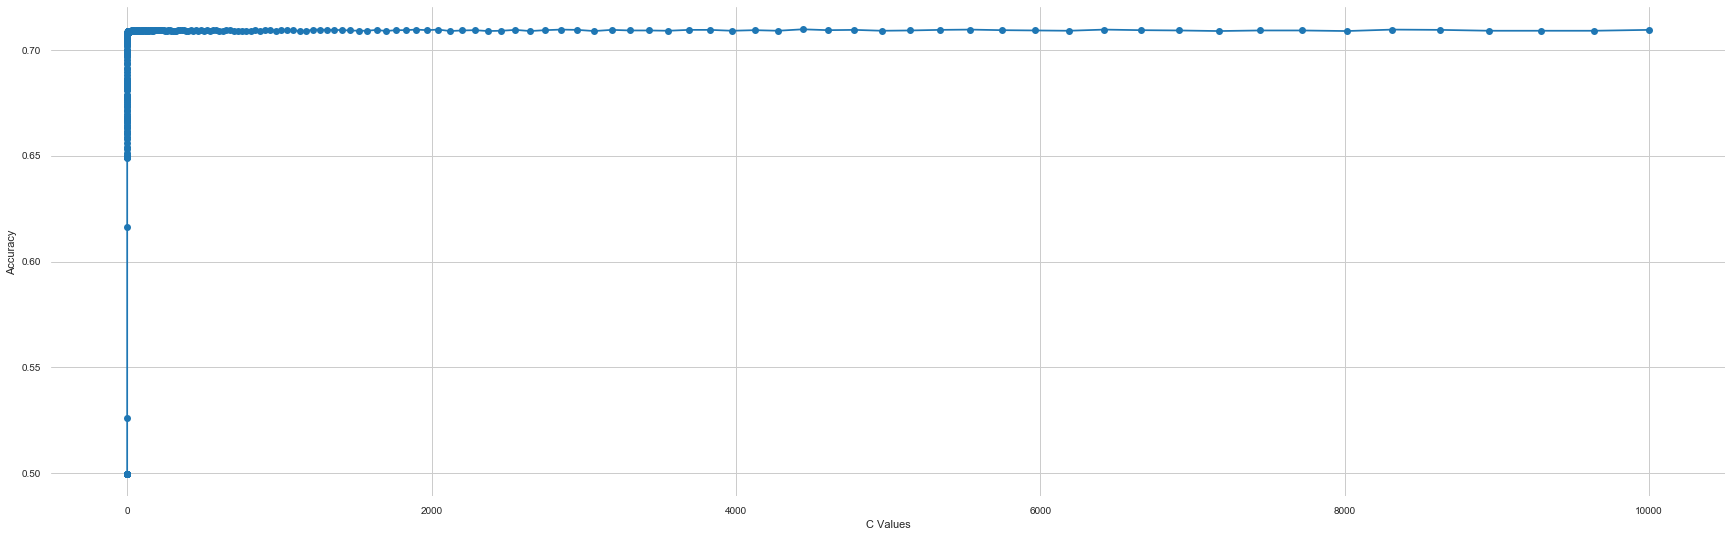

In [162]:
fig, axs = plt.subplots(1, 1, figsize=(30, 9))
axs.plot(logRegCVSD.Cs_, logRegCVSD.scores_[1].mean(axis=0), marker='o')
axs.plot(logRegCVSD.C_, logRegCVSD.scores_[1].mean(axis=0).max(), marker='x',
         markersize=15)
# axs.set_xscale('log')
axs.set_title('')
axs.set_xlabel('C Values')
axs.set_ylabel('Accuracy')
axs.grid()

# print max accuracy
print(logRegCVSD.scores_[1].mean(axis=0).max())

In [163]:
# Calculate accuracy of the model
# Make predictions using the training data
train_preds = logRegCVSD.predict(X_train)
# Score those predictions
train_acc = accuracy_score(train_preds, y_train)

# Make predictions on the testing data
test_preds = logRegCVSD.predict(X_test)
# Score those predictions
test_acc = accuracy_score(test_preds, y_test)

# Print out the accuracy for each
print("Train Accuracy: {:.2f}%".format(train_acc*100))
print("Test Accuracy: {:.2f}%".format(test_acc*100))

Train Accuracy: 50.00%
Test Accuracy: 48.89%


### Decision Tree

#### Fit original model

In [164]:
# Define model
clf = DecisionTreeClassifier(random_state=7, min_samples_leaf=25)
# Fit model
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=7, splitter='best')

#### Find accuracy for train/test data

In [165]:
# Find the accuracy on the training data
train_data_accuracy = accuracy_score(clf.predict(X_train), y_train)

# Find the accuracy on the testing data
test_data_accuracy = accuracy_score(clf.predict(X_test) , y_test)

print('The accuracy on the training data is {:.0f}%'.format(train_data_accuracy*100))
print('The accuracy on the testing data is {:.0f}%'.format(test_data_accuracy*100))

The accuracy on the training data is 75%
The accuracy on the testing data is 61%


#### Tree model using GridSearch approach

In [ ]:
# Redo tree but with GridSearchCV for fine-tuning the model
clf = DecisionTreeClassifier(random_state=7)
# Create a dictionary of parameters & ranges to test against
parameters = {'min_samples_leaf': range(25,500), 'max_depth': range(3,50)}
# Create GridSearchCV
gsCV = GridSearchCV(clf, parameters, cv=5, return_train_score=True)
# Train the model
gsCV.fit(X_train, y_train)
# Get the results of the grid search approach
grid_results = pd.DataFrame(gsCV.cv_results_)
# Order the results on best test score and print out the top ten
grid_results.sort_values('rank_test_score').head(10)